#### Imports

In [11]:
!ls

sample_data


In [12]:
# -*- coding: utf-8 -*-
#!wget -c https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
#!unzip MURA-v1.1.zip
#!rm MURA-v1.1.zip
!ls

--2018-12-25 06:16:23--  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3380245855 (3.1G) [application/zip]
Saving to: ‘MURA-v1.1.zip’

MURA-v1.1.zip       100%[===================>]   3.15G  12.3MB/s    in 4m 5s   

2018-12-25 06:20:28 (13.1 MB/s) - ‘MURA-v1.1.zip’ saved [3380245855/3380245855]

Archive:  MURA-v1.1.zip
   creating: MURA-v1.1/
  inflating: MURA-v1.1/train_labeled_studies.csv  
  inflating: MURA-v1.1/valid_labeled_studies.csv  
  inflating: MURA-v1.1/train_image_paths.csv  
  inflating: MURA-v1.1/valid_image_paths.csv  
   creating: MURA-v1.1/valid/
   creating: MURA-v1.1/valid/XR_ELBOW/
   creating: MURA-v1.1/valid/XR_ELBOW/patient11817/
   creating: MURA-v1.1/valid/XR_ELBOW/patient11817/study1_positive/
 extracting: MURA-v1.1/valid/XR_ELBOW/patient11817/study1_positive/im

In [0]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import keras
pd.options.display.max_colwidth = 100
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.preprocessing import image
from keras.applications.mobilenetv2 import preprocess_input
from keras.applications import MobileNet
from keras.callbacks import (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard)
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.metrics import binary_accuracy, binary_crossentropy
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenetv2 import MobileNetV2
from keras.preprocessing import image as k_im_prep
from keras.models import Model
from keras import backend as K
from keras.models import Sequential

#### Training Data

**output is list of paths to images and list of corresponding labels**

In [0]:
#did this because it gave an error at sample  5307 or near it if took all
sample_e=5307
sample_s2=5339

**TODO: handle that unread sample problem**
If couldn't handle it then see how many labels are +ve and how are -ve to have intuition about model results , maybe because too many samples of one class and little of other

In [15]:
#make dataframe
studies=pd.read_csv('MURA-v1.1/train_labeled_studies.csv', sep=',',header=None)
#making a list of paths and a corresponding list of labels
#using non vectorized for speed
#wrist studies
wrist_tr=studies[studies[0].str.contains("WRIST")==True]
wrist_tr=np.array(wrist_tr)

#making a list of paths and a corresponding list of labels
#using non vectorized for speed
wrist_paths_tr=[]
wrist_labels_tr=[]
for i in tqdm( range(wrist_tr.shape[0]) ):
    study_path=wrist_tr[i][0]
    study_label=wrist_tr[i][1]
    study_files = [f for f in listdir(study_path) if isfile(join(study_path, f))]
    for image in study_files:
        wrist_paths_tr.append(study_path + image)
        wrist_labels_tr.append(study_label)

wrist_paths_tr=np.array(wrist_paths_tr)
wrist_labels_tr=np.array(wrist_labels_tr)

print("\n\n")
print(wrist_paths_tr.shape)
print(wrist_labels_tr.shape)


100%|██████████| 3460/3460 [00:00<00:00, 16547.84it/s]




(9756,)
(9756,)


### Todo : issue , images after preprocessing look different

read images from paths to array of images

In [16]:
wrist_images_tr=[]
for path in tqdm(wrist_paths_tr[:sample_e]):
    wrist=k_im_prep.load_img(path, target_size=(224, 224))
    wrist_images_tr.append(np.array(wrist))
#new start
for path in tqdm(wrist_paths_tr[sample_s2:]):
    wrist=k_im_prep.load_img(path, target_size=(224, 224))
    wrist_images_tr.append(np.array(wrist))
#making it a numpy array instead of python list
wrist_images_tr=np.array(wrist_images_tr)

#wrist_labels_tr=wrist_labels_tr[:sample_e]
print("\n\n")
print(wrist_images_tr.shape)
print(wrist_labels_tr.shape)

100%|██████████| 4417/4417 [00:20<00:00, 218.69it/s]





(9724, 224, 224, 3)
(9756,)


In [0]:
start=wrist_labels_tr[:sample_e]
end=wrist_labels_tr[sample_s2:]
wrist_labels_tr=np.hstack([  start, end  ])


In [18]:
print("\n")
print(wrist_images_tr.shape)
print(wrist_labels_tr.shape)
print(start.shape[0]+end.shape[0])



(9724, 224, 224, 3)
(9724,)
9724


1


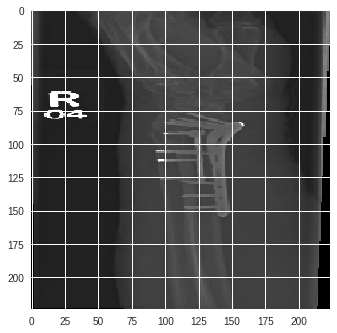

In [19]:
#visualizing random sample after preprocesiing 
index=999
plt.imshow(wrist_images_tr[index])
print(wrist_labels_tr[index])

#### Validation Data

In [20]:
#make dataframe
studies=pd.read_csv('MURA-v1.1/valid_labeled_studies.csv', sep=',',header=None)
#making a list of paths and a corresponding list of labels
#using non vectorized for speed
#wrist studies
wrist_val=studies[studies[0].str.contains("WRIST")==True]
wrist_val=np.array(wrist_val)

#making a list of paths and a corresponding list of labels
#using non vectorized for speed
wrist_paths_val=[]
wrist_labels_val=[]
for i in tqdm( range(wrist_val.shape[0]) ):
    study_path=wrist_val[i][0]
    study_label=wrist_val[i][1]
    study_files = [f for f in listdir(study_path) if isfile(join(study_path, f))]
    for image in study_files:
        wrist_paths_val.append(study_path + image)
        wrist_labels_val.append(study_label)

wrist_paths_val=np.array(wrist_paths_val)
wrist_labels_val=np.array(wrist_labels_val)

wrist_images_val=[]
for path in tqdm(wrist_paths_val):
    wrist=k_im_prep.load_img(path, target_size=(224, 224))
    wrist_images_val.append(np.array(wrist))

wrist_images_val=np.array(wrist_images_val)

print(wrist_images_val.shape)




100%|██████████| 659/659 [00:03<00:00, 215.51it/s]


(659, 224, 224, 3)


label=  0


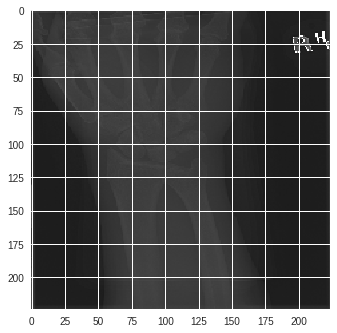

In [21]:
#visualizing random sample
index=650
plt.imshow(wrist_images_val[index])
print("label= ",wrist_labels_val[index])

In [22]:
#data bias : train
print("0 normal, 1 abnormal")
unique, counts = np.unique(wrist_labels_tr, return_counts=True)
print(dict(zip(unique, counts)))
#val
unique, counts = np.unique(wrist_labels_val, return_counts=True)
print(dict(zip(unique, counts)))


0 normal, 1 abnormal
{0: 5737, 1: 3987}
{0: 364, 1: 295}


### Model

In [0]:
def make_FT_model(base=1, imagenet=True, freeze_all=True, add_denses=True):
  
  #weights of pretrained model
  if (imagenet==True):
    w='imagenet'
  else:
    w=None
  
  #initializing pretrained model
  if (base==0):
    base_model = MobileNetV2(input_shape= (224, 224, 3),weights=w, include_top=False)
  elif (base == 1):
    base_model = DenseNet169(input_shape= (224, 224, 3),weights=w, include_top=False)
  elif (base == 2):
    base_model = InceptionV3(input_shape= (224, 224, 3),weights=w, include_top=False)
 
  if (freeze_all):
    #freeze layers of densenet
    for layer in base_model.layers:
      layer.trainable= False 
  
  # add a global spatial average pooling layer
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  
  if(add_denses):
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(1, activation='sigmoid')(x)
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
  else:
    # just feature extractor
    model = Model(inputs=base_model.input, output=x)
  
  
  return model

In [24]:
model=make_FT_model(base=1, imagenet=True, freeze_all=True, add_denses=True)
#m.summary()
#Choose adam or RMSprop ?!
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(wrist_images_tr, wrist_labels_tr, epochs=5, validation_data=(wrist_images_val, wrist_labels_val), shuffle=True, verbose=1 )

Train on 9724 samples, validate on 659 samples
Epoch 1/5
9724/9724 [==============================] - 136s 14ms/step - loss: 0.6294 - acc: 0.6768 - val_loss: 5.2098 - val_acc: 0.5524
Epoch 2/5
9724/9724 [==============================] - 96s 10ms/step - loss: 0.5305 - acc: 0.7496 - val_loss: 4.5167 - val_acc: 0.5524
Epoch 3/5
9724/9724 [==============================] - 97s 10ms/step - loss: 0.4992 - acc: 0.7620 - val_loss: 3.2179 - val_acc: 0.5524
Epoch 4/5
9724/9724 [==============================] - 97s 10ms/step - loss: 0.4868 - acc: 0.7756 - val_loss: 4.2986 - val_acc: 0.5524
Epoch 5/5
9724/9724 [==============================] - 97s 10ms/step - loss: 0.4733 - acc: 0.7773 - val_loss: 5.0763 - val_acc: 0.5524


In [25]:
loss,accuracy=model.evaluate(x=wrist_images_tr, y=wrist_labels_tr, batch_size=128, verbose=1)
print("train loss",loss,"train accuracy",accuracy)

9724/9724 [==============================] - 101s 10ms/step
train loss 4.767649873558636 train accuracy 0.5901892225421638


In [26]:
loss,accuracy=model.evaluate(x=wrist_images_val, y=wrist_labels_val, batch_size=128, verbose=1)
print("validation loss",loss,"validation accuracy",accuracy)

659/659 [==============================] - 6s 10ms/step
validation loss 5.076308795848751 validation accuracy 0.5523520485584219


** Current point: generalizing functions and code cleaning+ seeing early stopping callback**

All unsolved problems:
* why is it in every epoch the result is the same, all results exactly the same
* which layers to freeze and which to train + should I train TL before freezing it ?
* data augmentation to generate more data
* recording variation in accuracy after every change to get intuition
* no matter Mobilenet,densenet, added or removed denses same results !! exact same even fractions
* the fear of overfitting over validation set
* what does outputted loss represent ? how to read the number ?
* Get more training data through solving the reading problem and getting the remaining 4k images
* normalization step and its effect on accuracy
* should I use 1 or two neurons at output layer ?
* binary crossentropy weights
* justifying parameter use and discovering useful params
* try training with model unfrozen with imagenet and without it
* make a function to record and tabulate outputs
* could we add precision or recall metric ? change accuracy?
* why doesn't it work if removed GlobalAveragePooling line?
* see if want to freeze less layers
* generalize file reading functions